In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
train_df = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/train.csv')
train_df.head()

,Unique ID,Rider_ID,category_x,Circuit_Length_km,Laps,Grid_Position,Avg_Speed_kmh,Track_Condition,Humidity_%,Tire_Compound_Front,...,air,ground,starts,finishes,with_points,podiums,wins,min_year,max_year,years_active
0,1894944,2659,Moto2,4.874,22,17,264.66,Wet,61,Hard,...,23,35,53,45,41,4,0,2018,2021,4
1,23438,5205,Moto2,3.875,24,7,177.56,Wet,77,Soft,...,12,12,27,27,22,2,1,1975,1983,8
2,939678,7392,Moto3,5.647,25,5,317.74,Dry,87,Soft,...,22,23,45,43,10,0,0,1982,1989,8
3,1196312,7894,Moto3,4.810,19,3,321.82,Wet,43,Soft,...,23,35,192,172,155,16,9,1994,2009,16
4,1033899,6163,MotoGP,5.809,25,21,239.92,Wet,47,Hard,...,22,31,175,146,132,29,17,2011,2021,11


In [4]:
train_df.shape

(1914056, 45)

In [5]:
train_df.dtypes

Unique ID                            int64
Rider_ID                             int64
category_x                          object
Circuit_Length_km                  float64
Laps                                 int64
Grid_Position                        int64
Avg_Speed_kmh                      float64
Track_Condition                     object
Humidity_%                           int64
Tire_Compound_Front                 object
Tire_Compound_Rear                  object
Penalty                             object
Championship_Points                  int64
Championship_Position                int64
Session                             object
year_x                               int64
sequence                             int64
rider                                int64
team                                 int64
bike                                 int64
position                             int64
points                             float64
shortname                           object
circuit_nam

In [6]:
train_df.columns

Index(['Unique ID', 'Rider_ID', 'category_x', 'Circuit_Length_km', 'Laps',
       'Grid_Position', 'Avg_Speed_kmh', 'Track_Condition', 'Humidity_%',
       'Tire_Compound_Front', 'Tire_Compound_Rear', 'Penalty',
       'Championship_Points', 'Championship_Position', 'Session', 'year_x',
       'sequence', 'rider', 'team', 'bike', 'position', 'points', 'shortname',
       'circuit_name', 'rider_name', 'team_name', 'bike_name',
       'Lap_Time_Seconds', 'Corners_per_Lap',
       'Tire_Degradation_Factor_per_Lap', 'Pit_Stop_Duration_Seconds',
       'Ambient_Temperature_Celsius', 'Track_Temperature_Celsius', 'weather',
       'track', 'air', 'ground', 'starts', 'finishes', 'with_points',
       'podiums', 'wins', 'min_year', 'max_year', 'years_active'],
      dtype='object')

In [7]:
train_df.isnull().sum()

Unique ID                               0
Rider_ID                                0
category_x                              0
Circuit_Length_km                       0
Laps                                    0
Grid_Position                           0
Avg_Speed_kmh                           0
Track_Condition                         0
Humidity_%                              0
Tire_Compound_Front                     0
Tire_Compound_Rear                      0
Penalty                            321292
Championship_Points                     0
Championship_Position                   0
Session                                 0
year_x                                  0
sequence                                0
rider                                   0
team                                    0
bike                                    0
position                                0
points                                  0
shortname                               0
circuit_name                      

In [8]:
train_df['Penalty'].value_counts()

Penalty
DNS             321908
+3s             320314
DNF             318145
Ride Through    316548
+5s             315849
Name: count, dtype: int64

In [9]:
#handling missing values in penalty column
train_df['Penalty'] = train_df['Penalty'].fillna('No Penalty')

In [10]:
train_df['Penalty'].isnull().sum()

0

In [11]:
penalty_map = {
    'No Penalty': 0,
    'DNS': 1,
    'DNF': 2,
    'Ride Through': 3,
    '+3s': 4,
    '+5s': 5
}
train_df['Penalty_encoded'] = train_df['Penalty'].map(penalty_map)

In [12]:
train_df['Penalty_encoded'].unique()

array([4, 5, 2, 1, 3, 0])

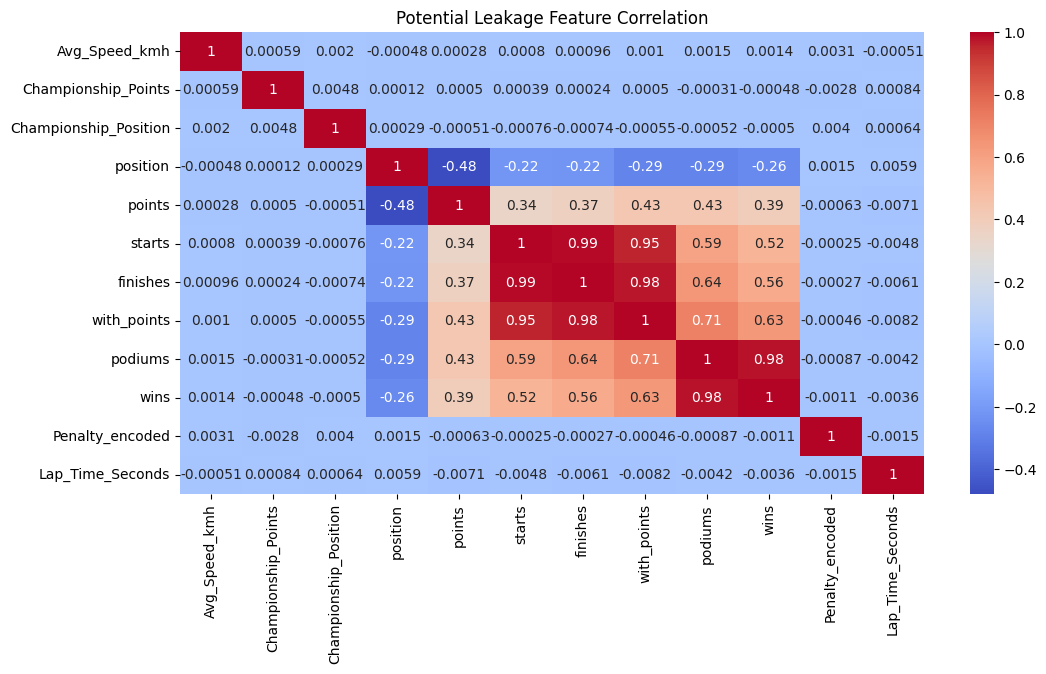

In [13]:
leakage_check_cols = ['Avg_Speed_kmh', 'Championship_Points',
                     'Championship_Position','position', 
                     'points', 'starts', 'finishes', 'with_points',
       'podiums', 'wins', 'Penalty_encoded' ]
plt.figure(figsize=(12,6))
sns.heatmap(train_df[leakage_check_cols + ['Lap_Time_Seconds']].corr(), annot=True, cmap='coolwarm')
plt.title("Potential Leakage Feature Correlation")
plt.show()

safely can remove the columns points, position, avg_speed_kmh

In [14]:
# dividing features 

irrelevant_cols = ['Unique ID', 'Rider_ID', 'Penalty','Session','Avg_Speed_kmh',
                  'sequence' , 'position' , 'points', 'rider', 'team', 'bike','shortname',
       'circuit_name', 'rider_name', 'team_name', 'bike_name', 'min_year', 'max_year']

numerical_cols = ['Circuit_Length_km' ,'Laps' , 
                  'Grid_Position',
                  'Championship_Points', 
                  'Championship_Position','Corners_per_Lap',
                  'Tire_Degradation_Factor_per_Lap',
                  'Pit_Stop_Duration_Seconds', 'years_active',
                  'Penalty_encoded'
                 ]

categorical_cols = ['category_x', 'Tire_Compound_Front','Tire_Compound_Rear', 'Track_Condition', 'weather', 'track']

weather_cols = ['Humidity_%', 'Ambient_Temperature_Celsius', 'Track_Temperature_Celsius', 'air', 'ground']

performance_cols = ['starts', 'finishes', 'with_points','podiums','wins']


In [15]:
train_df['win_rate'] = train_df['wins'] / train_df['starts'].replace(0,1)
train_df['podium_rate'] = train_df['podiums'] / train_df['starts'].replace(0,1)
train_df['points_rate'] = train_df['with_points'] / train_df['starts'].replace(0,1)
train_df['finish_rate'] = train_df['finishes'] / train_df['starts'].replace(0,1)

# weather based features
train_df['temp_diff'] = train_df['Track_Temperature_Celsius'] - train_df['Ambient_Temperature_Celsius']
train_df['air_ground_diff'] = train_df['air'] - train_df['ground']

# categorical encoding
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)

In [16]:
feature_cols = numerical_cols  + weather_cols
derived_cols = ['win_rate', 'podium_rate', 'points_rate', 'finish_rate', 'temp_diff', 'air_ground_diff']

# encoded categorical cols 
encoded_cols = [col for col in train_df.columns if any(prefix in col for prefix in ['category_x_',
                                                                                    'Tire_Compound_Front_','Tire_Compound_Rear_',
                                                                                    'Track_Condition_', 'weather_', 'track_'])]
# final feature list
feature_cols = feature_cols + derived_cols + encoded_cols

In [17]:
feature_cols

['Circuit_Length_km',
 'Laps',
 'Grid_Position',
 'Championship_Points',
 'Championship_Position',
 'Corners_per_Lap',
 'Tire_Degradation_Factor_per_Lap',
 'Pit_Stop_Duration_Seconds',
 'years_active',
 'Penalty_encoded',
 'Humidity_%',
 'Ambient_Temperature_Celsius',
 'Track_Temperature_Celsius',
 'air',
 'ground',
 'win_rate',
 'podium_rate',
 'points_rate',
 'finish_rate',
 'temp_diff',
 'air_ground_diff',
 'category_x_Moto3',
 'category_x_MotoGP',
 'Tire_Compound_Front_Medium',
 'Tire_Compound_Front_Soft',
 'Tire_Compound_Rear_Medium',
 'Tire_Compound_Rear_Soft',
 'Track_Condition_Wet',
 'weather_Cloudy',
 'weather_Partly cloudy',
 'weather_Raining',
 'weather_Sunny',
 'track_Wet']

In [18]:
X = train_df[feature_cols]
y = train_df['Lap_Time_Seconds']

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

In [27]:
val_df = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/val.csv')
val_df


,Unique ID,Rider_ID,category_x,Circuit_Length_km,Laps,Grid_Position,Avg_Speed_kmh,Track_Condition,Humidity_%,Tire_Compound_Front,...,air,ground,starts,finishes,with_points,podiums,wins,min_year,max_year,years_active
0,1733872,6065,Moto2,4.248,24,5,293.12,Wet,33,Hard,...,22,31,54,54,49,15,6,1966,1970,5
1,1778161,5781,Moto2,4.907,20,2,310.31,Wet,32,Soft,...,26,35,120,110,89,4,1,1996,2005,10
2,1205004,3780,Moto2,4.162,24,15,237.39,Wet,89,Medium,...,28,47,290,262,258,105,54,2001,2021,19
3,578473,8193,MotoGP,3.889,18,3,275.55,Wet,32,Soft,...,22,31,134,115,105,5,2,1998,2010,13
4,2248803,1632,Moto2,4.088,24,19,297.81,Wet,59,Soft,...,26,35,106,86,45,1,0,2010,2018,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273432,1906151,7777,MotoGP,3.726,25,18,309.09,Dry,48,Hard,...,22,31,163,144,140,62,45,2001,2012,12
273433,770254,1310,Moto2,4.820,22,13,321.30,Wet,62,Hard,...,12,12,192,179,164,42,22,1997,2015,15
273434,1417001,5851,Moto2,4.827,20,16,223.36,Dry,62,Hard,...,26,35,19,17,5,0,0,1998,2001,4
273435,2245360,4265,Moto3,5.586,19,2,309.03,Wet,50,Medium,...,21,31,55,55,46,5,3,1979,1989,11


In [28]:
val_df.isnull().sum()

Unique ID                              0
Rider_ID                               0
category_x                             0
Circuit_Length_km                      0
Laps                                   0
Grid_Position                          0
Avg_Speed_kmh                          0
Track_Condition                        0
Humidity_%                             0
Tire_Compound_Front                    0
Tire_Compound_Rear                     0
Penalty                            45620
Championship_Points                    0
Championship_Position                  0
Session                                0
year_x                                 0
sequence                               0
rider                                  0
team                                   0
bike                                   0
position                               0
points                                 0
shortname                              0
circuit_name                           0
rider_name      

In [29]:
#handling missing values in penalty column
val_df['Penalty'] = val_df['Penalty'].fillna('No Penalty')

In [30]:
val_df['Penalty'].isnull().sum()

0

In [31]:
penalty_mapping = {
    'No Penalty': 0,
    'DNS': 1,
    'DNF': 2,
    'Ride Through': 3,
    '+3s': 4,
    '+5s': 5
}
val_df['Penalty_encoded'] = val_df['Penalty'].map(penalty_mapping)

In [32]:
val_df['Penalty_encoded'].isnull().sum()

0

In [33]:
val_df['win_rate'] = val_df['wins'] / val_df['starts'].replace(0,1)
val_df['podium_rate'] = val_df['podiums'] / val_df['starts'].replace(0,1)
val_df['points_rate'] = val_df['with_points'] / val_df['starts'].replace(0,1)
val_df['finish_rate'] = val_df['finishes'] / val_df['starts'].replace(0,1)

# weather based features
val_df['temp_diff'] = val_df['Track_Temperature_Celsius'] - val_df['Ambient_Temperature_Celsius']
val_df['air_ground_diff'] = val_df['air'] - val_df['ground']

# categorical encoding
val_df = pd.get_dummies(val_df, columns=categorical_cols, drop_first=True)

In [34]:
X_val = val_df[feature_cols]
y_val = val_df['Lap_Time_Seconds']
x_val_scaled = scaler.transform(X_val)


In [37]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=30, n_jobs = -1, random_state=42)
model.fit(X_train_scaled, y)

y_pred = model.predict(x_val_scaled)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print('Validation MSE: ', mse)
print('Validation R2: ', r2)

Validation MSE:  1.1765607596787885e-07
Validation R2:  0.9999999991125984


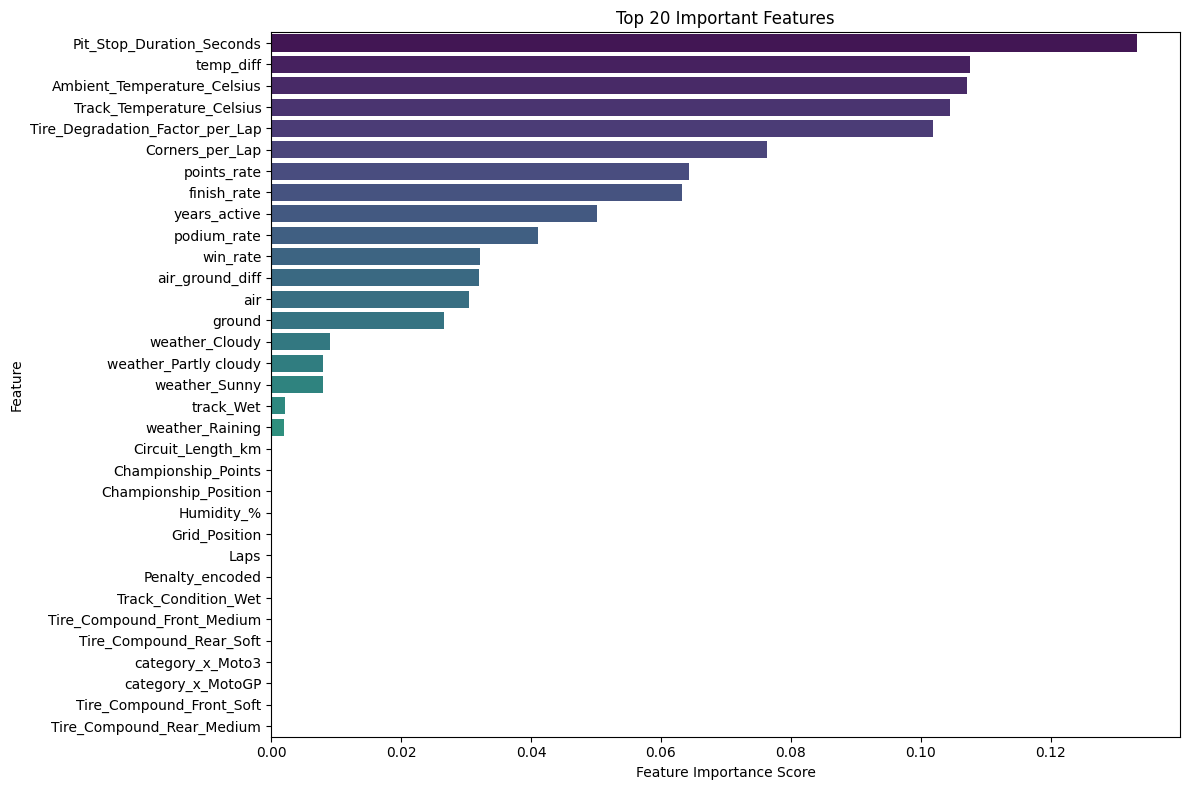

In [39]:
importances = model.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(35), palette='viridis')
plt.title('Top 20 Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [40]:
test_df = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/test.csv')
test_df.head()

,Unique ID,Rider_ID,category_x,Circuit_Length_km,Laps,Grid_Position,Avg_Speed_kmh,Track_Condition,Humidity_%,Tire_Compound_Front,...,air,ground,starts,finishes,with_points,podiums,wins,min_year,max_year,years_active
0,288307,6533,MotoGP,5.316,19,1,284.38,Dry,44,Hard,...,16,19,92,86,47,2,0,1981,1993,13
1,704288,4800,Moto2,3.861,19,2,328.98,Dry,43,Hard,...,28,47,406,373,365,178,111,1996,2021,26
2,951491,7907,Moto3,3.954,18,21,165.56,Dry,77,Soft,...,27,46,138,134,120,13,7,1993,2007,15
3,2591721,4844,Moto3,4.074,21,21,258.46,Dry,74,Medium,...,21,29,83,70,37,0,0,1998,2007,10
4,1202653,4802,Moto2,4.096,25,21,319.60,Dry,84,Hard,...,27,46,134,115,105,5,2,1998,2010,13


In [41]:
test_df.shape

(546874, 44)

In [42]:
test_df.columns

Index(['Unique ID', 'Rider_ID', 'category_x', 'Circuit_Length_km', 'Laps',
       'Grid_Position', 'Avg_Speed_kmh', 'Track_Condition', 'Humidity_%',
       'Tire_Compound_Front', 'Tire_Compound_Rear', 'Penalty',
       'Championship_Points', 'Championship_Position', 'Session', 'year_x',
       'sequence', 'rider', 'team', 'bike', 'position', 'points', 'shortname',
       'circuit_name', 'rider_name', 'team_name', 'bike_name',
       'Corners_per_Lap', 'Tire_Degradation_Factor_per_Lap',
       'Pit_Stop_Duration_Seconds', 'Ambient_Temperature_Celsius',
       'Track_Temperature_Celsius', 'weather', 'track', 'air', 'ground',
       'starts', 'finishes', 'with_points', 'podiums', 'wins', 'min_year',
       'max_year', 'years_active'],
      dtype='object')

In [43]:

test_df.isnull().sum()

Unique ID                              0
Rider_ID                               0
category_x                             0
Circuit_Length_km                      0
Laps                                   0
Grid_Position                          0
Avg_Speed_kmh                          0
Track_Condition                        0
Humidity_%                             0
Tire_Compound_Front                    0
Tire_Compound_Rear                     0
Penalty                            91555
Championship_Points                    0
Championship_Position                  0
Session                                0
year_x                                 0
sequence                               0
rider                                  0
team                                   0
bike                                   0
position                               0
points                                 0
shortname                              0
circuit_name                           0
rider_name      

In [44]:
#handling missing values in penalty column
test_df['Penalty'] = test_df['Penalty'].fillna('No Penalty')

In [45]:
penalty_mapping_test = {
    'No Penalty': 0,
    'DNS': 1,
    'DNF': 2,
    'Ride Through': 3,
    '+3s': 4,
    '+5s': 5
}
test_df['Penalty_encoded'] = test_df['Penalty'].map(penalty_mapping_test)

In [46]:
test_df['Penalty_encoded'].isnull().sum()

0

In [47]:
test_df['win_rate'] = test_df['wins'] / test_df['starts'].replace(0,1)
test_df['podium_rate'] = test_df['podiums'] / test_df['starts'].replace(0,1)
test_df['points_rate'] = test_df['with_points'] / test_df['starts'].replace(0,1)
test_df['finish_rate'] = test_df['finishes'] / test_df['starts'].replace(0,1)

# weather based features
test_df['temp_diff'] = test_df['Track_Temperature_Celsius'] - test_df['Ambient_Temperature_Celsius']
test_df['air_ground_diff'] = test_df['air'] - test_df['ground']

# categorical encoding
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

In [48]:
Id = test_df['Unique ID']
test_df = test_df[X.columns]

In [49]:
test_scaled = scaler.transform(test_df)

In [50]:
test_predictions = model.predict(test_scaled)

In [51]:
submission = pd.DataFrame({
    'Unique ID': Id,
    'Lap_Time_Seconds': test_predictions
})

In [52]:
submission.to_csv('submission.csv', index=False)